## Setup

As always, we start with the usual imports and set a variant that supports automatic differentation.

In [1]:
import matplotlib.pyplot as plt 
import drjit as dr
import mitsuba as mi
import miepython
import numpy as np
mi.set_variant('cuda_mono')

In [2]:
mi.variants()

['scalar_rgb',
 'scalar_spectral',
 'cuda_ad_rgb',
 'llvm_ad_rgb',
 'llvm_mono',
 'llvm_ad_mono',
 'cuda_ad_mono',
 'cuda_ad_spectral',
 'cuda_spectral',
 'cuda_mono',
 'llvm_ad_spectral',
 'llvm_spectral']

### Creating multiple sensors

We cannot hope to obtain a robust volumetric reconstruction using only a single reference image. Multiple viewpoints are needed to sufficiently constrain the reconstructed volume density.  Using a multi-view optimization we can recover volume parameters that generalize to novel views (and illumination conditions).

In this tutorial, we use 5 sensors placed on a half circle around the origin. For the simple optimization in this tutorial this is sufficient, but more complex scenes may require using significantly more views (e.g., using 50-100 sensors is not unreasonable).

In [3]:
from mitsuba import ScalarTransform4f as T

sensor_count = 5
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = T.rotate([0, 1, 0], angle)
    sensor_to_world = T.look_at(target=[0, 0, 0], origin=[5, 5 ,5], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 60,
        'to_world': sensor_rotation @ sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 512, 'height': 512,
            'filter': {'type': 'tent'},
            'pixel_format':'luminance'
        }
    }))


In [4]:
x = np.linspace(0.4, 0.7, 31) 
#m=(2.170184597+0.00059399*x**2+0.02303464*x**-2-0.000499485*x**-4+0.000178796*x**-6)**.5
m=(2.161659124+0.000495188*x**2+0.02138179*x**-2+0.000058838*x**-4+0.000087632*x**-6)**.5

radius = 0.2                    # in microns
param = 2 * np.pi * radius / x
qext, qsca, qback, g = miepython.mie(m, param)


In [5]:
qsca[0]*(radius)**-3,x[0]

(453.11591983433993, 0.4)

In [6]:
qsca[-1]*(radius)**-3,x[-1]

(155.64520728834353, 0.7)

In [7]:
def get_scene_dict(scale):
    scene_dict = {
        'type': 'scene',
        'integrator': {'type': 'prbvolpath'},
        'object': {
            'type': 'cube',
            'bsdf': {'type': 'null'},
            'to_world': T.scale(3),
            'interior': {
                'type': 'heterogeneous',
                'sigma_t': {
                    'type': 'gridvolume',
                    'filename': 'scenes/volume.vol',
                    'to_world': T.rotate([1, 0, 0], -90).scale(10).translate(-0.5)
                },
                'albedo': 0.99,
                'scale': 2/scale
                
            }
        },
        'bunny':{
            'type': 'ply',
            'filename': 'scenes/meshes/bunny.ply',
            'to_world':T.translate(-0.25).translate([-0.5,-0.5,0.5]).scale(8),
            'bsdf':{'type':'diffuse' ,'reflectance': 0.9}
        },
        'emitter_light': {'type': 'constant','radiance': {'type': 'spectrum',"value": 0.9}}
    }
    return scene_dict


In [8]:
#Samples from 1 to 4 with an interval of 0.2
scaling_factor_smoke = np.linspace(1, 4, 16)

In [9]:
scene_refs = []
for scale in scaling_factor_smoke:
    print(scale)
    scene_refs.append(mi.load_dict(get_scene_dict(scale)))


#scene_refs.append(mi.load_dict(get_scene_dict(100)))
ref_spp = 128
ref_images = [mi.render(scene_refs[i], sensor=sensors[1], spp=ref_spp) for i in range(len(scene_refs))]

1.0
1.2
1.4
1.6
1.8
2.0
2.2
2.4000000000000004
2.6
2.8
3.0
3.2
3.4000000000000004
3.6
3.8000000000000003
4.0


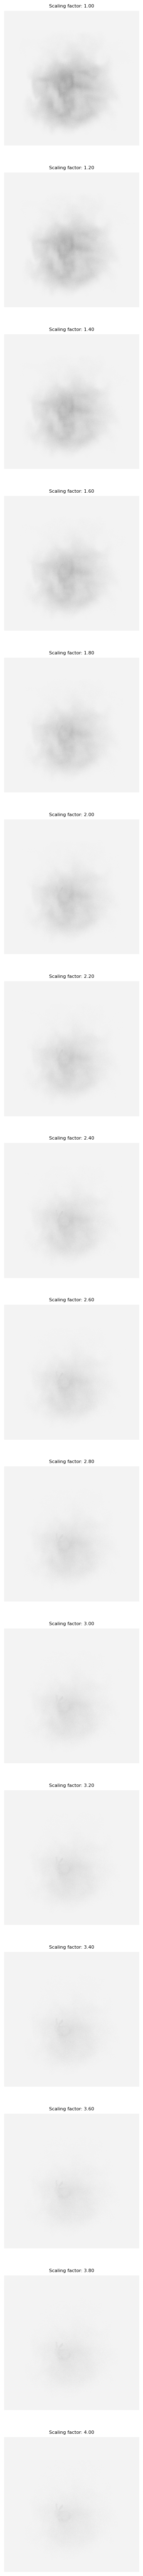

In [10]:
#make figure size in terms of ref_images
fig, axs = plt.subplots(len(ref_images),1 ,figsize=(15, 5*len(ref_images)))

for i in range(len(ref_images)):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    #put title as the scaling factor used upto 2 decimal places
    #Make title smaller and figure bigger
    axs[i].set_title(f"Scaling factor: {scaling_factor_smoke[i]:.2f}", fontsize=8)
    axs[i].axis('off')